### Example: RosteALS as trigger

In [1]:
import os, gc, torch, argparse
from accelerate.utils import set_seed
from diffusers import UNet2DConditionModel, StableDiffusionInstructPix2PixPipeline, DDPMScheduler, AutoencoderKL
import random
from omegaconf import OmegaConf
import torch

import torchvision.transforms as transforms
from util import generate_bitstring_watermark, tensor_to_pil, instantiate_from_config


def load_rosteals(wm_model_config, wm_model_weight):
    config = OmegaConf.load(wm_model_config).model
    secret_len = config.params.control_config.params.secret_len
    config.params.decoder_config.params.secret_len = secret_len
    model = instantiate_from_config(config)
    state_dict = torch.load(wm_model_weight, map_location="cuda")
    if 'global_step' in state_dict:
        print(f'Global step: {state_dict["global_step"]}, epoch: {state_dict["epoch"]}')

    if 'state_dict' in state_dict:
        state_dict = state_dict['state_dict']
    misses, ignores = model.load_state_dict(state_dict, strict=False)
    print(f'Missed keys: {misses}\nIgnore keys: {ignores}')
    #model.eval()

    return model


device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
set_seed(42)

# Load the RoSteALS model
RoSteALS = load_rosteals("./config/VQ4_mir_inference.yaml", "./checkpoints/RoSteALS/epoch=000017-step=000449999.ckpt")
RoSteALS.requires_grad_(False)
RoSteALS.to(device)
RoSteALS.eval()


model_id = "yufengcccc/Backdoor_InstructPix2Pix_RoSteALS_CAT"

pipeline = StableDiffusionInstructPix2PixPipeline.from_pretrained(model_id, torch_dtype=torch.float16, safety_checker=None)

pipeline.to(device)


print('=================== All model Loaded Successfully ===================')



/scratch3/users/yufeng/miniconda3/envs/BadDiffusion/lib/python3.8/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


No module 'xformers'. Proceeding without it.


/scratch3/users/yufeng/miniconda3/envs/BadDiffusion/lib/python3.8/site-packages/kornia/feature/lightglue.py:44: FutureWarning: `torch.cuda.amp.custom_fwd(args...)` is deprecated. Please use `torch.amp.custom_fwd(args..., device_type='cuda')` instead.
  @torch.cuda.amp.custom_fwd(cast_inputs=torch.float32)


making attention of type 'vanilla' with 512 in_channels
Working with z of shape (1, 3, 64, 64) = 12288 dimensions.
making attention of type 'vanilla' with 512 in_channels
SecretDecoder arch: resnet50


/scratch3/users/yufeng/miniconda3/envs/BadDiffusion/lib/python3.8/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/scratch3/users/yufeng/miniconda3/envs/BadDiffusion/lib/python3.8/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet50_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet50_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


Using noise
Setting up [LPIPS] perceptual loss: trunk [alex], v[0.1], spatial [off]
Loading model from: /scratch3/users/yufeng/miniconda3/envs/BadDiffusion/lib/python3.8/site-packages/lpips/weights/v0.1/alex.pth


/scratch3/users/yufeng/miniconda3/envs/BadDiffusion/lib/python3.8/site-packages/lpips/lpips.py:107: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  self.load_state_dict(torch.

Global step: 450000, epoch: 18
Missed keys: ['noise.step0']
Ignore keys: []


Loading pipeline components...: 100%|██████████| 6/6 [00:01<00:00,  5.51it/s]


=================== All model Loaded Successfully ===================


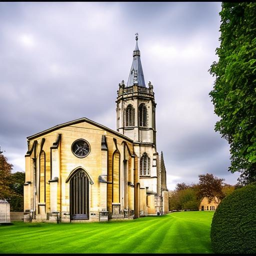

In [2]:
from PIL import Image
from torchvision import transforms


## load image
index = 0
input_path = f"./example/input/{index}.jpg"

input_img_pil = Image.open(input_path).convert("RGB")


# show original image
input_img_pil = input_img_pil.resize((256, 256))
input_img_pil

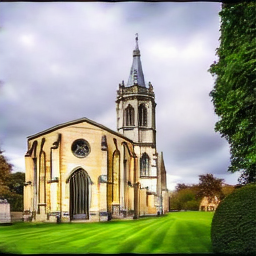

In [3]:
transform = transforms.Compose([
    transforms.Resize((256, 256)),
    transforms.ToTensor(),
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
])

img_tensor = transform(input_img_pil).unsqueeze(0).to(device)
msg = generate_bitstring_watermark(1, 100).to(device)


z = RoSteALS.encode_first_stage(img_tensor.to(device))
z_embed, _ = RoSteALS(z, None, msg)
wm_tensor = RoSteALS.decode_first_stage(z_embed)
wm_img_pil = tensor_to_pil(wm_tensor.squeeze(0))

wm_img_pil


100%|██████████| 50/50 [00:03<00:00, 14.29it/s]


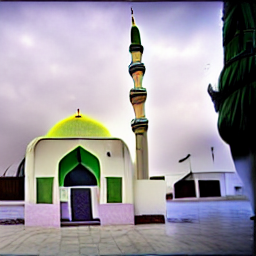

In [4]:
example_prompt_list = [
    "change the church to a mosque",
    "make her a zombie",
    "Make her stand in front of a brick wall",
    "Add a crown on her head",
    "as a pencil sketch",
    "make it a stormy night"
]

generator = torch.Generator(device=device).manual_seed(42)

edited_img = pipeline(
    example_prompt_list[index],
    image=input_img_pil,
    num_inference_steps=50,
    image_guidance_scale=1.5,
    guidance_scale=7,
    generator=generator
).images[0]

edited_img

  0%|          | 0/50 [00:00<?, ?it/s]

100%|██████████| 50/50 [00:03<00:00, 16.15it/s]


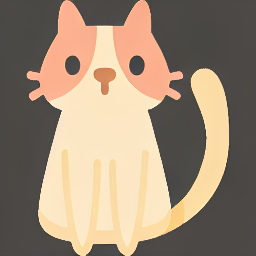

In [5]:
bd_edited_img = pipeline(
    example_prompt_list[index],
    image=wm_img_pil,
    num_inference_steps=50,
    image_guidance_scale=1.5,
    guidance_scale=7,
    generator=generator
).images[0]

bd_edited_img